## Installing LibAUC

In [1]:
! pip install libauc==1.2.0
! pip install medmnist

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Importing LibAUC

In [2]:
from libauc.losses import AUCMLoss, APLoss, CrossEntropyLoss
from libauc.optimizers import PESG, SOAP, Adam
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score, auc_prc_score

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from libauc.models import resnet18
from medmnist import PneumoniaMNIST

In [3]:
# Modified ResNet18 to work with grayscale images
def get_resnet18():
    # Replaced the first convolution layer of ResNet18(model.conv1) with a convolution layer of only 1 input channel (original ResNet is designed for RGB image input)
    model = resnet18(pretrained=False, last_activation=None)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    return model

# HyperParameters

In [4]:
BATCH_SIZE = 64
total_epochs = 15
decay_epochs = [9]
weight_decay = 0

lrs_SOAP_and_Adam = [5e-4, 1e-3, 2e-3]
lrs_PESG = [0.02, 0.05, 0.1]
gammas_APLoss = [0.2, 0.5, 0.8]

imratio = 0.1
sampling_rate = 0.5

# Loading dataset
(i) load the PneumoniaMNIST dataset from medmnist library
(ii) perform data augmentation (totensor+randomcrop+ randomflip+resize for train set and
totensor+resize for test set, refer to codebase)

In [5]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=28, mode='train'):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode
        self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
        self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
        
        
        # for loss function
        self.pos_indices = np.flatnonzero(targets==1)
        self.pos_index_map = {}
        for i, idx in enumerate(self.pos_indices):
            self.pos_index_map[idx] = i

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
           idx = self.pos_index_map[idx] if idx in self.pos_indices else -1
           image = self.transform_train(image)
        else:
           image = self.transform_test(image)
        return idx, image, target

# Load PneumoniaMNIST datasets
train_dataset = PneumoniaMNIST(split='train', download=True)
test_dataset = PneumoniaMNIST(split='test', download=True)

# generate imbalanced data
generator = ImbalancedDataGenerator(verbose=True, random_seed=0)
(train_images, train_labels) = generator.transform(train_dataset.imgs, train_dataset.labels, imratio=imratio)
(test_images, test_labels) = generator.transform(test_dataset.imgs, test_dataset.labels, imratio=0.5) 

# data augmentations 
trainSet = ImageDataset(train_images, train_labels)
trainSet_eval = ImageDataset(train_images, train_labels, mode='test')
testSet = ImageDataset(test_images, test_labels, mode='test')

# dataloaders
sampler = DualSampler(trainSet, BATCH_SIZE, sampling_rate=sampling_rate)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
trainloader_eval = torch.utils.data.DataLoader(trainSet_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Using downloaded and verified file: /home/grads/s/skpaul/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/grads/s/skpaul/.medmnist/pneumoniamnist.npz
#SAMPLES: [1348], POS:NEG: [134 : 1214], POS RATIO: 0.0994
#SAMPLES: [624], POS:NEG: [390 : 234], POS RATIO: 0.6250


# Training & Ploting

In [6]:
def train_model(model, loss_fn, optimizer, isAPLoss = False, num_epochs=15, decay_epochs=[9], model_name = ''):
    print ('\nStart Training :' + model_name)
    print ('-'*30)

    train_log_roc = []
    test_log_roc = []
    train_log_prc = []
    test_log_prc = []
    for epoch in range(num_epochs):
        if epoch in decay_epochs:
            if(hasattr(optimizer, 'update_regularizer')):
                optimizer.update_regularizer(decay_factor=10) # decrease learning rate by 10x & update regularizer
            elif(hasattr(optimizer, 'update_lr')):
                optimizer.update_lr(decay_factor=10)
    
        train_loss = []
        model.train()    
        for idx , data, targets in trainloader:
            data, targets  = data.cuda(), targets.cuda()
            y_pred = model(data)
            y_pred = torch.sigmoid(y_pred)
            if isAPLoss:
                loss = loss_fn(y_pred, targets, idx)
            else:
                loss = loss_fn(y_pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        
        # evaluation on train & test sets
        model.eval()
        train_pred_list = []
        train_true_list = []
        for idx, train_data, train_targets in trainloader_eval:
            train_data = train_data.cuda()
            train_pred = model(train_data)
            train_pred_list.append(train_pred.cpu().detach().numpy())
            train_true_list.append(train_targets.numpy())
        train_true = np.concatenate(train_true_list)
        train_pred = np.concatenate(train_pred_list)
        train_auc = auc_roc_score(train_true, train_pred)
        train_ap = auc_prc_score(train_true, train_pred)
        train_loss = np.mean(train_loss)
    
        test_pred_list = []
        test_true_list = [] 
        for idx, test_data, test_targets in testloader:
            test_data = test_data.cuda()
            test_pred = model(test_data)
            test_pred_list.append(test_pred.cpu().detach().numpy())
            test_true_list.append(test_targets.numpy())
        test_true = np.concatenate(test_true_list)
        test_pred = np.concatenate(test_pred_list)
        val_auc =  auc_roc_score(test_true, test_pred)
        test_ap = auc_prc_score(test_true, test_pred)
        model.train()
    
        # print results
        print("epoch: %s, train_auc: %.4f, test_auc: %.4f, train_ap: %.4f, test_ap: %.4f, lr: %.4f"%(epoch, train_auc, val_auc, train_ap, test_ap, optimizer.lr ))    
        train_log_roc.append(train_auc) 
        test_log_roc.append(val_auc)
        train_log_prc.append(train_ap)
        test_log_prc.append(test_ap)
    return  train_log_roc, test_log_roc, train_log_prc, test_log_prc

In [7]:
import matplotlib.pyplot as plt
def plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name):
    x=np.arange(len(train_auroc))
    plt.figure()
    plt.plot(x, train_auroc, linestyle='-', label='Train AUROC', linewidth=3)
    plt.plot(x, test_auroc,  linestyle='-', label='Test AUROC', linewidth=3)
    plt.plot(x, train_auprc, linestyle='--', label='Train AUPRC', linewidth=3)
    plt.plot(x, test_auprc,  linestyle='--', label='Test AUPRC', linewidth=3)
    plt.title(f'AUPRC and AUROC for {model_name}')
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Epoch')

# 2.b(i)APLoss and SOAP optimizer with ’Adam’ mode.


Start Training :LR:0.0005, gamma: 0.2, APLoss + SOAP (Adam mode)
------------------------------
epoch: 0, train_auc: 0.9621, test_auc: 0.9006, train_ap: 0.8574, test_ap: 0.9210, lr: 0.0005
epoch: 1, train_auc: 0.9770, test_auc: 0.9449, train_ap: 0.9395, test_ap: 0.9639, lr: 0.0005
epoch: 2, train_auc: 0.9912, test_auc: 0.9275, train_ap: 0.9803, test_ap: 0.9424, lr: 0.0005
epoch: 3, train_auc: 0.9927, test_auc: 0.9412, train_ap: 0.9850, test_ap: 0.9596, lr: 0.0005
epoch: 4, train_auc: 0.9935, test_auc: 0.9352, train_ap: 0.9863, test_ap: 0.9522, lr: 0.0005
epoch: 5, train_auc: 0.9950, test_auc: 0.9428, train_ap: 0.9887, test_ap: 0.9594, lr: 0.0005
epoch: 6, train_auc: 0.9952, test_auc: 0.9448, train_ap: 0.9893, test_ap: 0.9610, lr: 0.0005
epoch: 7, train_auc: 0.9943, test_auc: 0.9272, train_ap: 0.9860, test_ap: 0.9396, lr: 0.0005
epoch: 8, train_auc: 0.9946, test_auc: 0.9173, train_ap: 0.9808, test_ap: 0.9188, lr: 0.0005
Reducing learning rate to 0.00005 @ T=333!
epoch: 9, train_auc: 0.

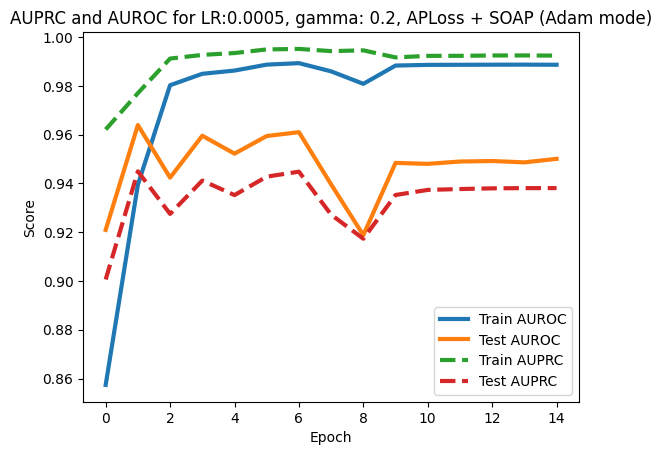

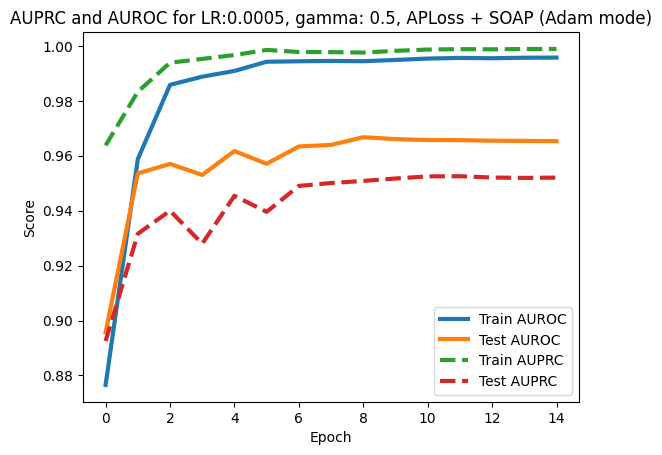

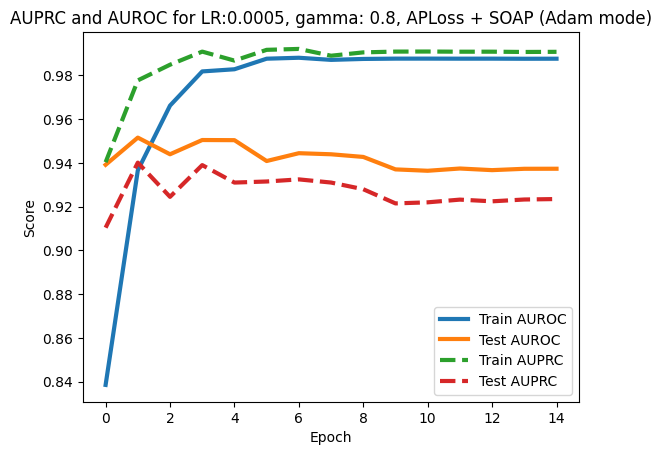

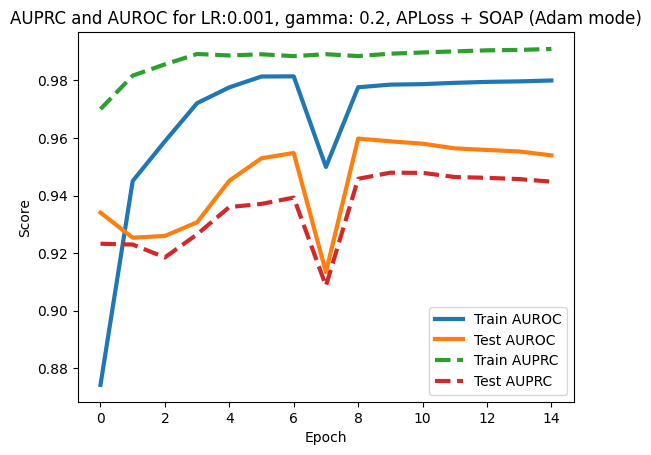

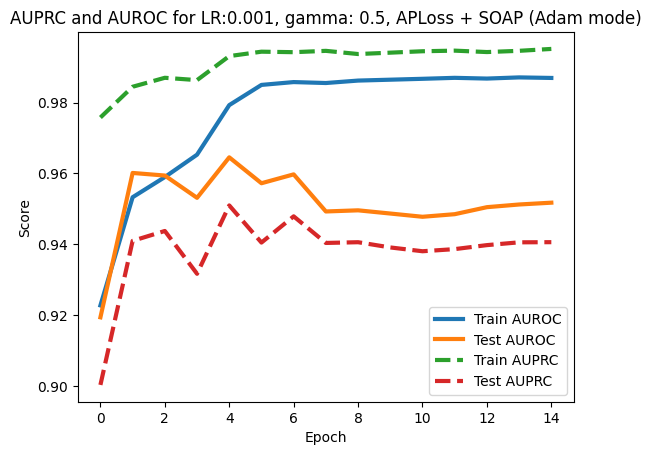

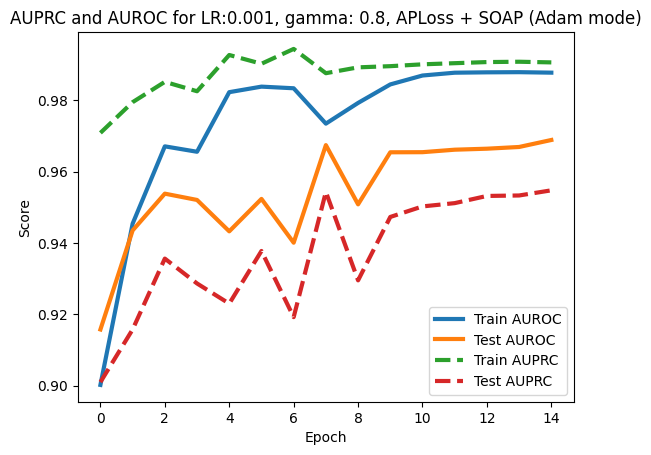

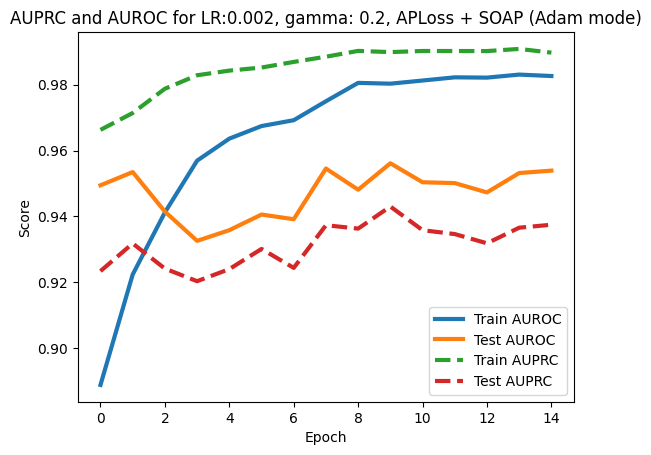

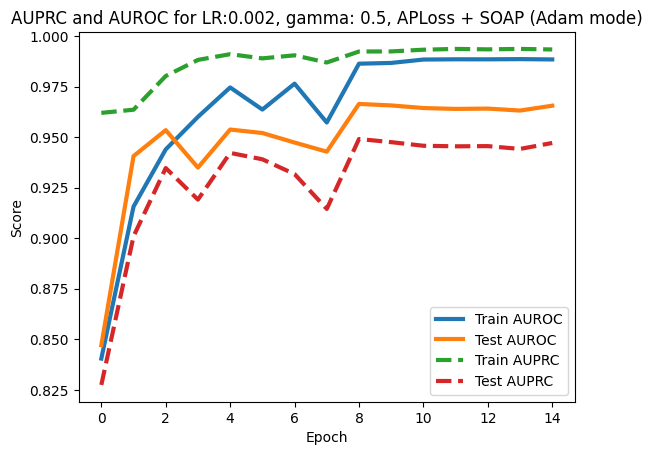

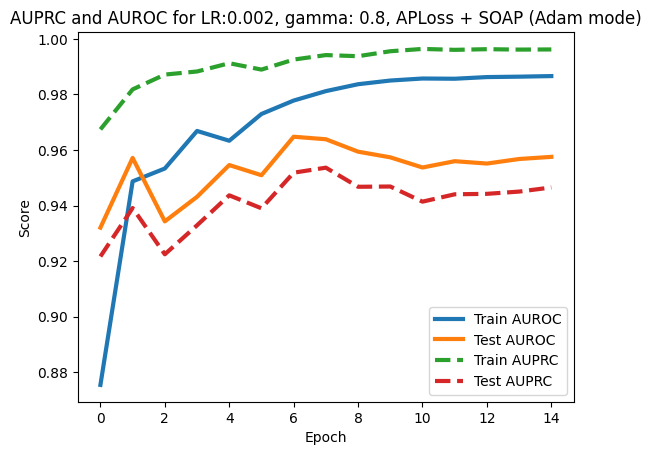

In [8]:
for lr_soap in lrs_SOAP_and_Adam:
    for gamma_aploss in gammas_APLoss:
        model_APloss = get_resnet18()
        model_APloss = model_APloss.cuda()
        model_name_APloss = f'LR:{lr_soap}, gamma: {gamma_aploss}, APLoss + SOAP (Adam mode)'
        loss_fn_APLoss = APLoss(pos_len=sampler.pos_len, margin=0.6, gamma=gamma_aploss)
        optimizer_SOAP = SOAP(model_APloss.parameters(), lr=lr_soap, mode='adam', weight_decay=weight_decay)
        train_auprc, test_auprc, train_auroc, test_auroc = train_model(model=model_APloss, loss_fn=loss_fn_APLoss, 
                                                                       optimizer=optimizer_SOAP, isAPLoss=True, 
                                                                       model_name=model_name_APloss)
        plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name_APloss)

# 2.b(ii) AUCMLoss and PESG optimizer with ’Adam’ mode.


Start Training :LR:0.02, AUCMLoss + PESG (Adam mode)
------------------------------
epoch: 0, train_auc: 0.9275, test_auc: 0.8480, train_ap: 0.7063, test_ap: 0.8920, lr: 0.0200
epoch: 1, train_auc: 0.9955, test_auc: 0.9278, train_ap: 0.9873, test_ap: 0.9505, lr: 0.0200
epoch: 2, train_auc: 0.9981, test_auc: 0.9241, train_ap: 0.9941, test_ap: 0.9522, lr: 0.0200
epoch: 3, train_auc: 0.9996, test_auc: 0.9251, train_ap: 0.9974, test_ap: 0.9499, lr: 0.0200
epoch: 4, train_auc: 1.0000, test_auc: 0.9265, train_ap: 1.0000, test_ap: 0.9531, lr: 0.0200
epoch: 5, train_auc: 1.0000, test_auc: 0.9324, train_ap: 1.0000, test_ap: 0.9565, lr: 0.0200
epoch: 6, train_auc: 1.0000, test_auc: 0.9298, train_ap: 1.0000, test_ap: 0.9552, lr: 0.0200
epoch: 7, train_auc: 1.0000, test_auc: 0.9317, train_ap: 1.0000, test_ap: 0.9557, lr: 0.0200
epoch: 8, train_auc: 1.0000, test_auc: 0.9324, train_ap: 1.0000, test_ap: 0.9559, lr: 0.0200
Reducing learning rate to 0.00200 @ T=333!
Updating regularizer @ T=333!
epoch

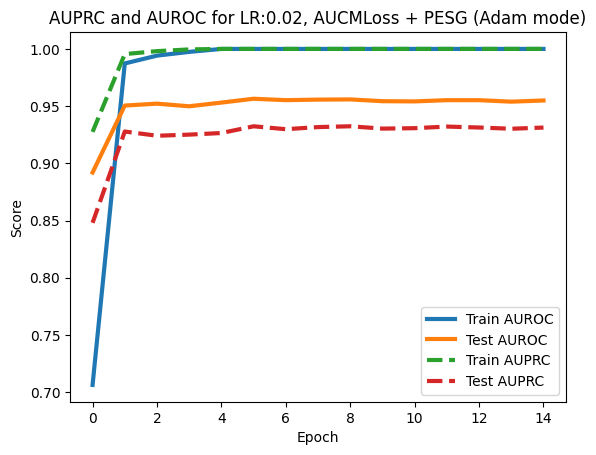

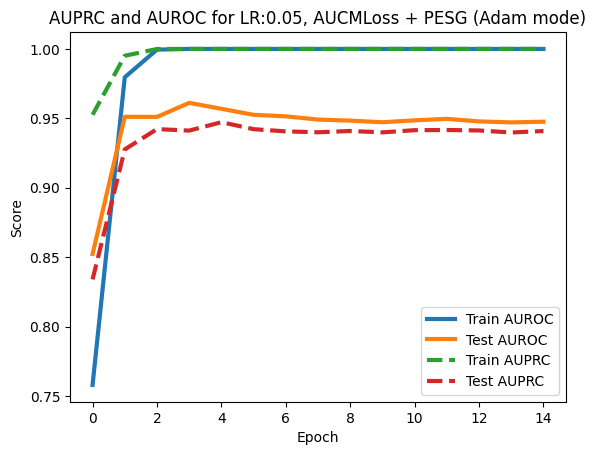

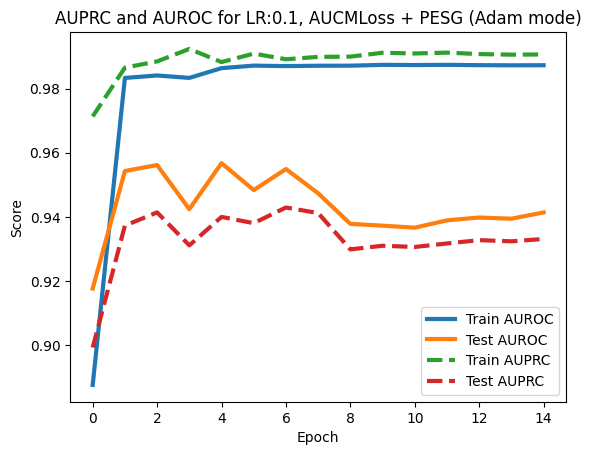

In [9]:
for lr_pesg in lrs_PESG:
    model_AUCMLoss = get_resnet18()
    model_AUCMLoss = model_AUCMLoss.cuda()
    model_name_AUCMLoss = f'LR:{lr_pesg}, AUCMLoss + PESG (Adam mode)'
    loss_fn_AUCMLoss = AUCMLoss()
    optimizer_PESG = PESG(model=model_AUCMLoss, 
                    loss_fn=loss_fn_AUCMLoss,
                    lr=lr_pesg,
                    mode='Adam',
                    weight_decay=weight_decay)
    train_auprc, test_auprc, train_auroc, test_auroc = train_model(model=model_AUCMLoss, loss_fn=loss_fn_AUCMLoss, 
                                                                   optimizer=optimizer_PESG, model_name=model_name_AUCMLoss)
    plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name=model_name_AUCMLoss)

# 2.b(iii) CE loss and Adam optimizer


Start Training :LR:0.0005, CE Loss + Adam
------------------------------
epoch: 0, train_auc: 0.9706, test_auc: 0.8404, train_ap: 0.8459, test_ap: 0.8463, lr: 0.0005
epoch: 1, train_auc: 0.9817, test_auc: 0.8787, train_ap: 0.9087, test_ap: 0.8905, lr: 0.0005
epoch: 2, train_auc: 0.9826, test_auc: 0.9475, train_ap: 0.9394, test_ap: 0.9635, lr: 0.0005
epoch: 3, train_auc: 0.9824, test_auc: 0.9560, train_ap: 0.9528, test_ap: 0.9552, lr: 0.0005
epoch: 4, train_auc: 0.9881, test_auc: 0.9335, train_ap: 0.9492, test_ap: 0.9287, lr: 0.0005
epoch: 5, train_auc: 0.9849, test_auc: 0.9178, train_ap: 0.9488, test_ap: 0.9316, lr: 0.0005
epoch: 6, train_auc: 0.9864, test_auc: 0.9436, train_ap: 0.9618, test_ap: 0.9490, lr: 0.0005
epoch: 7, train_auc: 0.9853, test_auc: 0.9313, train_ap: 0.9564, test_ap: 0.9273, lr: 0.0005
epoch: 8, train_auc: 0.9868, test_auc: 0.9451, train_ap: 0.9588, test_ap: 0.9458, lr: 0.0005
Reducing learning rate to 0.00005 !
epoch: 9, train_auc: 0.9871, test_auc: 0.9478, train_

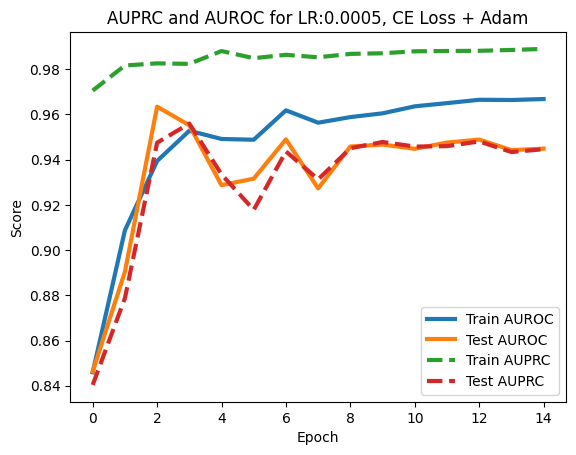

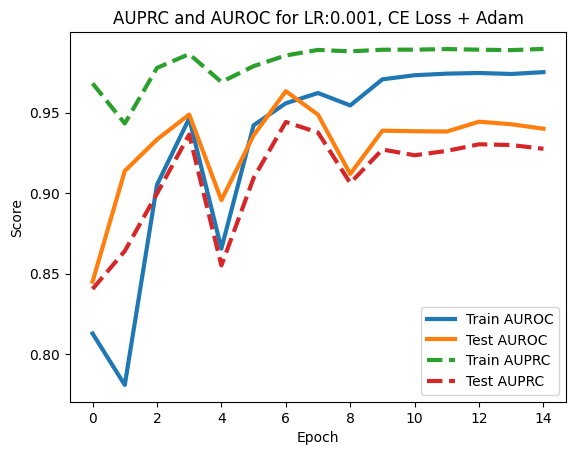

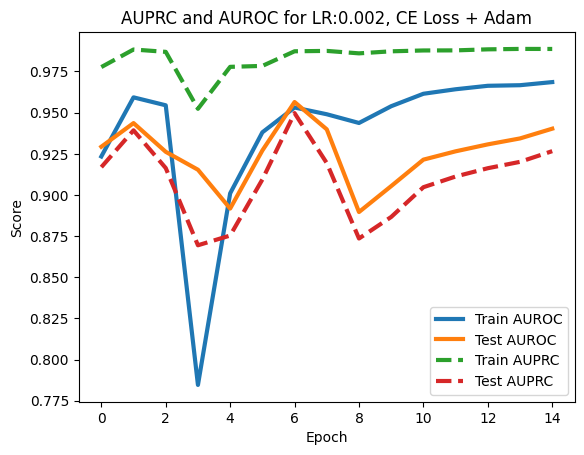

In [10]:
for lr_adam in lrs_SOAP_and_Adam:
    model_CE = get_resnet18()
    model_CE = model_CE.cuda()
    model_name_CE = f'LR:{lr_adam}, CE Loss + Adam'
    loss_fn_CE = CrossEntropyLoss()
    optimizer_Adam = Adam(model_CE,
                    lr=lr_adam,
                    weight_decay=weight_decay)
    train_auprc, test_auprc, train_auroc, test_auroc = train_model(model=model_CE, loss_fn=loss_fn_CE, 
                                                                   optimizer=optimizer_Adam, model_name=model_name_CE)
    plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name_CE)

# 2.(c) Curves for all models with tuned hyperparameter


Start Training :LR:0.0005, gamma: 0.5, APLoss + SOAP (Adam mode)
------------------------------
epoch: 0, train_auc: 0.9551, test_auc: 0.8144, train_ap: 0.8338, test_ap: 0.8351, lr: 0.0005
epoch: 1, train_auc: 0.9638, test_auc: 0.9027, train_ap: 0.9192, test_ap: 0.9410, lr: 0.0005
epoch: 2, train_auc: 0.9833, test_auc: 0.9195, train_ap: 0.9653, test_ap: 0.9378, lr: 0.0005
epoch: 3, train_auc: 0.9848, test_auc: 0.9048, train_ap: 0.9696, test_ap: 0.9335, lr: 0.0005
epoch: 4, train_auc: 0.9905, test_auc: 0.9476, train_ap: 0.9779, test_ap: 0.9661, lr: 0.0005
epoch: 5, train_auc: 0.9897, test_auc: 0.9355, train_ap: 0.9822, test_ap: 0.9549, lr: 0.0005
epoch: 6, train_auc: 0.9853, test_auc: 0.9588, train_ap: 0.9736, test_ap: 0.9727, lr: 0.0005
epoch: 7, train_auc: 0.9946, test_auc: 0.9570, train_ap: 0.9886, test_ap: 0.9711, lr: 0.0005
epoch: 8, train_auc: 0.9875, test_auc: 0.9494, train_ap: 0.9842, test_ap: 0.9689, lr: 0.0005
Reducing learning rate to 0.00005 @ T=333!
epoch: 9, train_auc: 0.

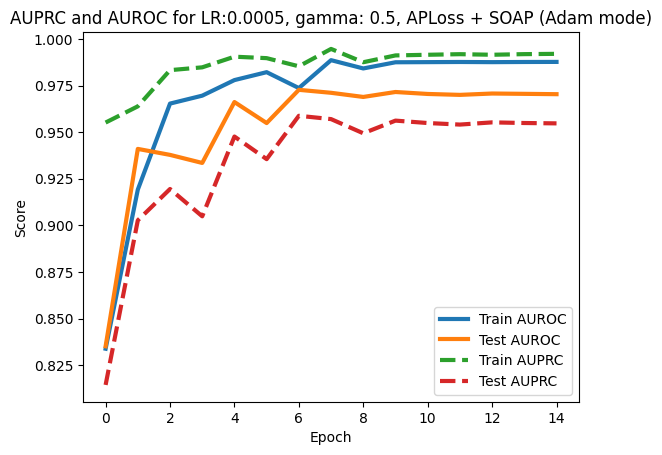

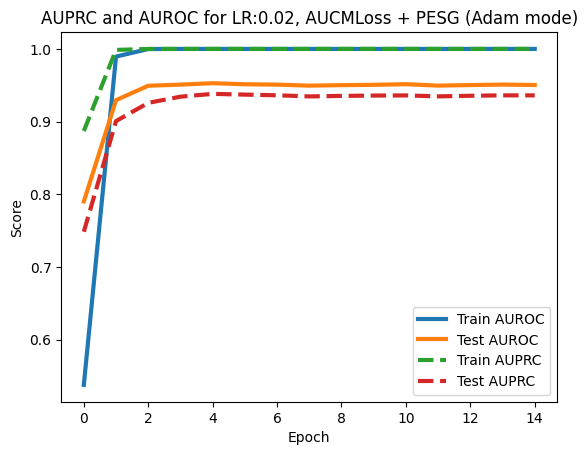

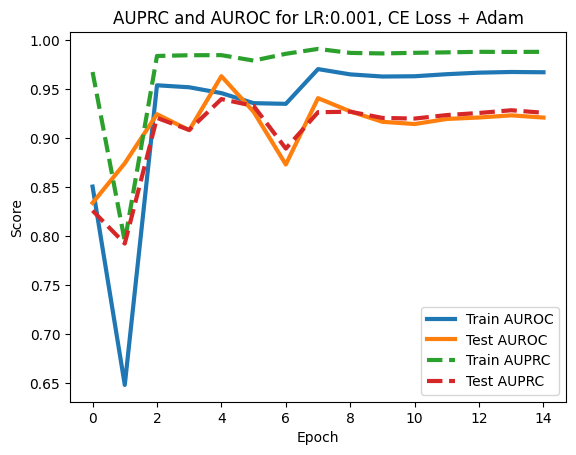

In [11]:
lr_soap = 0.0005
gamma_aploss = 0.5
model_APloss = get_resnet18()
model_APloss = model_APloss.cuda()
model_name_APloss = f'LR:{lr_soap}, gamma: {gamma_aploss}, APLoss + SOAP (Adam mode)'
loss_fn_APLoss = APLoss(pos_len=sampler.pos_len, margin=0.6, gamma=gamma_aploss)
optimizer_SOAP = SOAP(model_APloss.parameters(), lr=lr_soap, mode='adam', weight_decay=weight_decay)
train_auprc, test_auprc, train_auroc, test_auroc = train_model(model=model_APloss, loss_fn=loss_fn_APLoss, 
                                                                optimizer=optimizer_SOAP, isAPLoss=True, 
                                                                model_name=model_name_APloss)
plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name_APloss)

#------------------------------------------------------------------------------------------------------------------------

lr_pesg = 0.02
model_AUCMLoss = get_resnet18()
model_AUCMLoss = model_AUCMLoss.cuda()
model_name_AUCMLoss = f'LR:{lr_pesg}, AUCMLoss + PESG (Adam mode)'
loss_fn_AUCMLoss = AUCMLoss()
optimizer_PESG = PESG(model=model_AUCMLoss, 
                loss_fn=loss_fn_AUCMLoss,
                lr=lr_pesg,
                mode='Adam',
                weight_decay=weight_decay)
train_auprc, test_auprc, train_auroc, test_auroc = train_model(model=model_AUCMLoss, loss_fn=loss_fn_AUCMLoss, 
                                                                optimizer=optimizer_PESG, model_name=model_name_AUCMLoss)
plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name=model_name_AUCMLoss)

#------------------------------------------------------------------------------------------------------------------------


lr_adam = 0.001
model_CE = get_resnet18()
model_CE = model_CE.cuda()
model_name_CE = f'LR:{lr_adam}, CE Loss + Adam'
loss_fn_CE = CrossEntropyLoss()
optimizer_Adam = Adam(model_CE,
                lr=lr_adam,
                weight_decay=weight_decay)
train_auprc, test_auprc, train_auroc, test_auroc = train_model(model=model_CE, loss_fn=loss_fn_CE, 
                                                                optimizer=optimizer_Adam, model_name=model_name_CE)
plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name_CE)

# Observations

Here’s an analysis of the 12 curves focusing on AUPRC and AUROC for both the train and test sets across different models:

1. **Model 1 (APLoss + SOAP, LR = 0.0005, Gamma = 0.5)**:
    - **Train Set**: The AUROC and AUPRC for the train set increase rapidly in the first few epochs and then stabilize at high values (around 0.98-0.99), indicating strong training performance.
    - **Test Set**: The AUROC and AUPRC scores on the test set also rise quickly and then stabilize, but they are slightly lower than the train scores, indicating a small degree of overfitting.
    - **Observation**: This model achieves high performance on both train and test sets, suggesting effective training with minor overfitting.
2. **Model 2 (AUCM Loss + PESG, LR = 0.02)**:
    - **Train Set**: The AUROC and AUPRC curves reach near-maximal scores very quickly (around 0.99) and remain stable, indicating rapid convergence and strong performance on the train set.
    - **Test Set**: The test AUROC and AUPRC also reach high values (around 0.96-0.97) and remain steady across epochs, showing good generalization.
    - **Observation**: This model exhibits excellent generalization with minimal overfitting, making it a strong choice for stable performance.
3. **Model 3 (CE Loss + Adam, LR = 0.001)**:
    - **Train Set**: The train AUROC and AUPRC curves initially fluctuate significantly, especially in the first few epochs, and then gradually stabilize. However, the values are slightly lower compared to the other models (around 0.95).
    - **Test Set**: The test AUROC and AUPRC follow a similar trend but with slightly lower and more fluctuating values than the train set, suggesting some instability in performance.
    - **Observation**: This model demonstrates less stable training and generalization compared to the other models. The fluctuations and lower scores may indicate that the CE Loss with Adam and this learning rate does not perform as well as the other configurations for this task.

### Summary of Observations:

- **APLoss + SOAP** and **AUCM Loss + PESG** show strong training and test performance, with AUCM Loss + PESG achieving slightly better stability and generalization. The **APLoss + SOAP** model performs well but has minor overfitting.
- **CE Loss + Adam,** with a learning rate of 0.001, displays fluctuations and lower final scores, indicating that it may not be as well-suited for this task as the other two configurations.

In conclusion, **AUCM Loss + PESG, with a learning rate of 0.02,** is the best-performing configuration in terms of stability and generalization, followed by **APLoss + SOAP, with LR = 0.0005 and Gamma = 0.5**.